Goal: perform SCA from the ground up on our collection of nar sequences. First, an MSA was performed with the online tool Clustal Omega. The results were stored in `out/aaseqs/K00370/MSA_complete_seqs.aln-fasta`.

First, load in the MSA, make a numerical matrix. 

In [97]:
from Bio import AlignIO
import numpy as np
import matplotlib.pyplot as plt

# Load MSA
msa = AlignIO.read("../out/aaseqs/K00370/MSA_800_with_reference.aln-fasta", "fasta")

# Convert letters to numbers (0-20 for AAs + gap)
aa_to_int = {aa: i for i, aa in enumerate("ACDEFGHIKLMNPQRSTVWY-")}
msa_matrix = np.array([
    [aa_to_int[aa] for aa in record.seq] 
    for record in msa
])

print(f"MSA shape: {msa_matrix.shape} (sequences x positions)")

num_positions = msa_matrix.shape[1]
num_aas = 21  # 20 amino acids + gap


MSA shape: (119, 1417) (sequences x positions)


let's remove columns in the matrix with less than 50% coverage. The motivation for this is to handle length inflation from the MSA. 

Filtered MSA: 1229 positions (was 1417)


Text(0.5, 1.0, 'narG collection (pixel color = amino acid)')

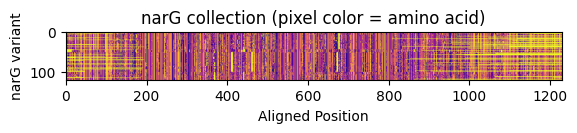

In [98]:
#let's remove columns in the matrix with less than 50% coverage. The motivation for this is to handle length inflation from the MSA. 
num_positions = len(msa_matrix[0])

num_seqs, num_positions = msa_matrix.shape


gap_threshold = 0.5 * num_seqs
clean_columns = [
    col for col in range(num_positions) 
    if np.sum(msa_matrix[:, col] == aa_to_int['-']) <= gap_threshold
]
msa_matrix = msa_matrix[:, clean_columns]
print(f"Filtered MSA: {msa_matrix.shape[1]} positions (was {num_positions})")
plt.show()
plt.imshow(msa_matrix, cmap = 'plasma')
plt.ylabel('narG variant')
plt.xlabel('Aligned Position')
plt.title('narG collection (pixel color = amino acid)')




functions defined below

In [99]:
num_seqs, num_positions = msa_matrix.shape

def raw_covariance(MSA):
    aa_to_int = {aa: i for i, aa in enumerate("ACDEFGHIKLMNPQRSTVWY-")}
    msa_matrix = MSA.copy()  
    
    

    num_aas = 20  # 20 b/ we're excluding gaps
    f_i = np.zeros((num_positions, num_aas))
    pseudocount = 1.0  # A pseudo count for stability
    
    for pos in range(num_positions):
        column = msa_matrix[:, pos]
        mask = (column != aa_to_int['-'])  
        valid_aas = column[mask]
        
        # count aa frequencies
        counts = np.bincount(valid_aas, minlength=num_aas) + pseudocount
        f_i[pos] = counts / (counts.sum() + num_aas*pseudocount)  # normalize
    
    # joint frequencies
    f_ij = np.zeros((num_positions, num_positions, num_aas, num_aas))
    
    for i in range(num_positions):
        for j in range(i, num_positions):  # only upper triangle
            pairs = msa_matrix[:, [i, j]]
            mask = (pairs[:, 0] != aa_to_int['-']) & (pairs[:, 1] != aa_to_int['-'])
            valid_pairs = pairs[mask]
            
            if len(valid_pairs) > 0:
                # Use einsum with pseudocount
                joint_counts = np.einsum('si,sj->ij', 
                                       np.eye(num_aas)[valid_pairs[:, 0]],
                                       np.eye(num_aas)[valid_pairs[:, 1]]) + pseudocount/num_aas
                f_ij[i, j] = joint_counts / (len(valid_pairs) + pseudocount)
                
                # Symmetrize
                if i != j:
                    f_ij[j, i] = f_ij[i, j].T
    
    # Compute stabilized covariance
    obs = f_ij
    exp = f_i[:, None, :, None] * f_i[None, :, None, :]
    
    # Clip differences to avoid extreme values
    diff = np.clip(obs - exp, -1, 1)  # Clip to [-1, 1] range
    cov_matrix = np.sqrt(np.sum(diff**2, axis=(-2, -1)))  # L2 norm
    
    return f_i, f_ij, cov_matrix

In [100]:
f_i, f_ij, cov_raw = raw_covariance(msa_matrix)

In [101]:
# Example background frequencies (Jones et al., 1992)
background = {
    'A': 0.078, 'C': 0.020, 'D': 0.053, 'E': 0.063,
    'F': 0.039, 'G': 0.072, 'H': 0.023, 'I': 0.053,
    'K': 0.059, 'L': 0.091, 'M': 0.022, 'N': 0.043,
    'P': 0.052, 'Q': 0.042, 'R': 0.051, 'S': 0.071,
    'T': 0.058, 'V': 0.066, 'W': 0.014, 'Y': 0.033
}

aa_order = "ACDEFGHIKLMNPQRSTVWY"
p_a = np.array([background[aa] for aa in aa_order])

In [102]:


def compute_cov_corrected(f_i, f_ij, p_a):
    """
    Memory-efficient computation of corrected covariance matrix.
    
    Args:
        f_i:    (L, A) array of position-specific amino acid frequencies
        f_ij:   (L, L, A, A) array of pairwise amino acid frequencies
        p_a:    (A,) array of background amino acid frequencies
    
    Returns:
        cov_corrected: (L, L) array of corrected covariation scores
    """
    L, A = f_i.shape
    cov_corrected = np.zeros((L, L))

    # pre compute correction terms, eps included to avoid nans/infs
    eps = 1e-10
    numerator = (f_i + eps) * (1 - p_a)
    denominator = (1 - f_i - eps) * p_a
    log_odds = np.log(numerator / denominator)
    log_odds = np.nan_to_num(log_odds, nan=0.0, posinf=0.0, neginf=0.0)

    for i in range(L):
        for j in range(L):
            cov_term = f_ij[i, j] - np.outer(f_i[i], f_i[j])
            correction = log_odds[i][:, None] * log_odds[j][None, :] * cov_term
            cov_corrected[i, j] = np.sum(correction**2)
    
    
    diag = np.diag(cov_corrected)
    cov_corrected /= np.sqrt(np.outer(diag, diag))


    return cov_corrected



In [103]:
cov = compute_cov_corrected(f_i, f_ij, p_a)

plot covariance matrix

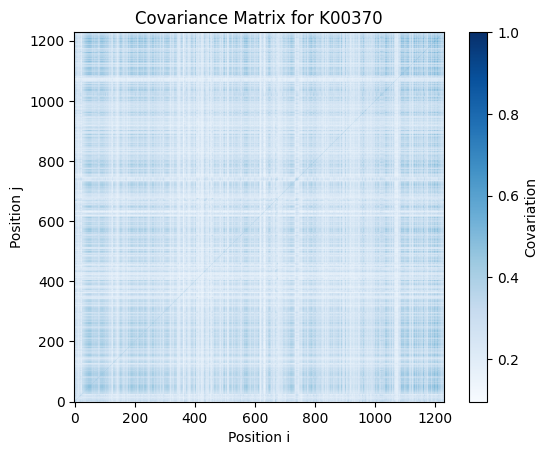

Text(0.5, 1.0, 'SCA Matrix for K00370')

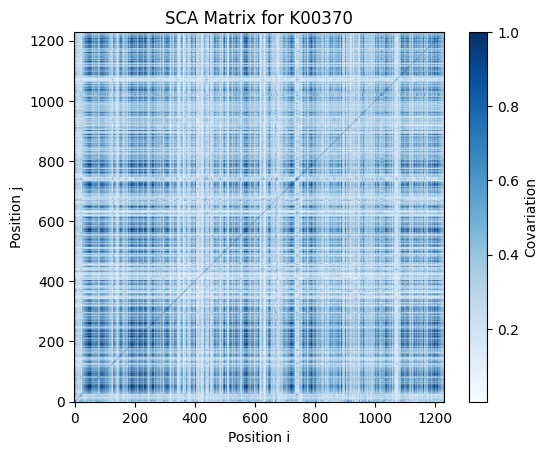

In [104]:

plt.imshow(cov_raw, cmap = 'Blues', origin = 'lower', vmax = 1)
plt.colorbar(label="Covariation")
plt.xlabel("Position i"); plt.ylabel("Position j")
plt.title('Covariance Matrix for K00370')
plt.show()

plt.imshow(cov, cmap = 'Blues', origin = 'lower', vmax = 1)
plt.colorbar(label="Covariation")
plt.xlabel("Position i"); plt.ylabel("Position j")
plt.title('SCA Matrix for K00370')

Move computation to a function

Look at modes

Text(0, 0.5, 'Singular value')

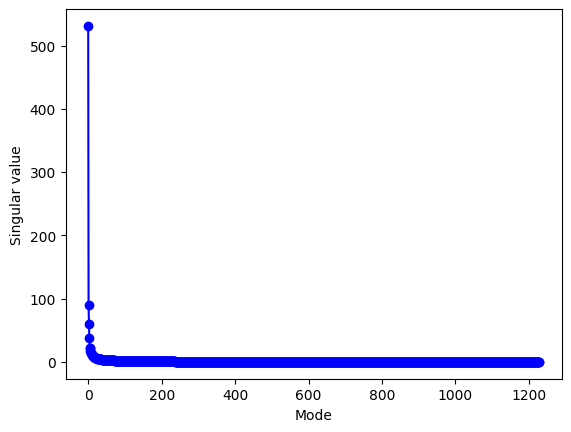

In [105]:
U, s, Vh = np.linalg.svd(cov)
plt.plot(s, 'o-', color = 'Blue')
plt.xlabel("Mode")
plt.ylabel("Singular value")

Compute first order statistics and a threshold.

[0.078 0.02  0.053 0.063 0.039 0.072 0.023 0.053 0.059 0.091 0.022 0.043
 0.052 0.042 0.051 0.071 0.058 0.066 0.014 0.033]
(119, 1229)
Conservation (KL divergence): [0.64757804 0.48316408 0.89520226 ... 0.86067655 0.27382532 1.25879786]


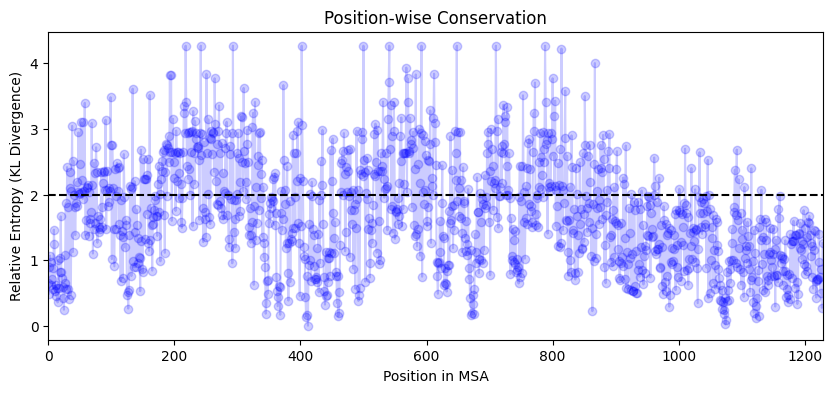

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 36, 39, 41, 42, 43, 44, 46, 55, 59, 60, 64, 66, 67, 68, 71, 73, 74, 78, 79, 80, 81, 82, 83, 85, 86, 92, 95, 96, 101, 104, 105, 107, 108, 112, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 128, 129, 132, 135, 136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 153, 157, 159, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 176, 178, 184, 185, 188, 196, 202, 208, 211, 212, 213, 225, 229, 240, 245, 246, 248, 249, 250, 255, 257, 267, 269, 272, 274, 276, 278, 284, 285, 286, 287, 290, 292, 294, 295, 296, 297, 298, 302, 304, 314, 318, 319, 320, 321, 322, 323, 326, 327, 329, 331, 335, 337, 340, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 359, 361, 362, 363, 364, 365, 366, 367, 368, 369, 371, 372, 376, 377, 378, 380, 381, 382, 383, 384, 385, 386, 387, 389, 391, 392, 397, 398, 399, 401, 405, 406, 

In [145]:


print(p_a)
print(msa_matrix.shape)
num_seqs, num_positions = msa_matrix.shape

def compute_conservation(msa_matrix, p_a):
    '''KL divergence from each position of our sequence to the global distribution'''
    num_positions = msa_matrix.shape[1]
    num_aas = len(p_a)
    conservation = np.zeros(num_positions)
    
    for i in range(num_positions):
        # Count AA frequencies at position i (+ pseudocount)
        counts = np.bincount(msa_matrix[:, i], minlength=num_aas)
        f_i = counts / counts.sum()
        
        # Compute KL divergence: D_KL(f_i || p_a)
        kl_div = 0 
        for j in range(20): #over each amino acid
            if f_i[j] > 0:
                kl_div += f_i[j] * np.log(f_i[j] / p_a[j])
        
        conservation[i] = kl_div
    
    return conservation

thres = 2

conservation = compute_conservation(msa_matrix, p_a)
print("Conservation (KL divergence):", conservation)

# Plot conservation
plt.figure(figsize=(10, 4))
plt.plot(conservation, '-o', color = 'Blue', alpha = 0.2)
plt.xlim(0, num_positions)
plt.xlabel("Position in MSA")
plt.ylabel("Relative Entropy (KL Divergence)")
plt.title("Position-wise Conservation")
plt.axhline(thres, linestyle = '--', color = 'black', alpha = 1)
plt.show()

remove = []
for i in range(len(conservation)):
    if conservation[i] < thres:
        remove.append(i)
print(remove)

delete poorly consersved regions

In [146]:

cov_filt = np.delete(cov, remove, axis=0) 
cov_filt = np.delete(cov_filt, remove, axis=1)

print(cov_filt.shape)

(434, 434)


Shuffle for signifance check

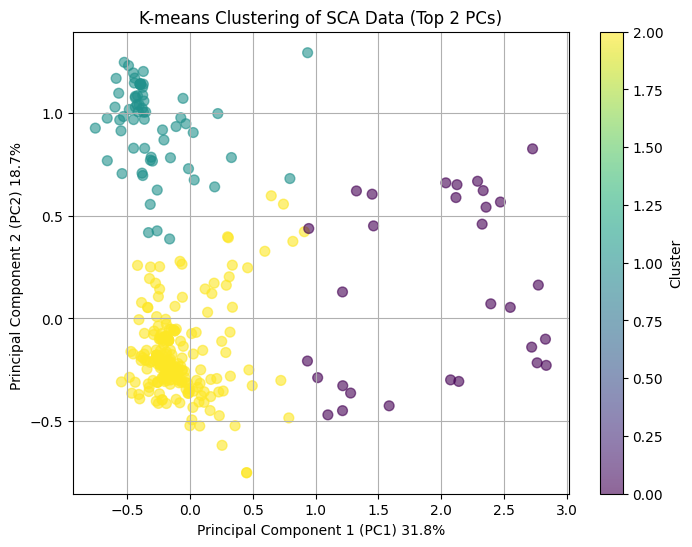

Variance explained by each PC (%): [31.83568717 18.71544172 17.57524543]


In [149]:
#do some mean centering and clustering

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

row_means = np.mean(cov_filt, axis=1)
col_means = np.mean(cov_filt, axis=0)
global_mean = np.mean(cov_filt)
cov_centered = cov_filt - np.outer(row_means, col_means) / global_mean

pca = PCA(n_components=3)  # Use top 3 PCs for visualization
pcs = pca.fit_transform(cov_centered)  # Project data onto PCs

# K-means clustering (e.g., 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pcs)

plt.figure(figsize=(8, 6))
plt.scatter(pcs[:, 0], pcs[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.6)
plt.xlabel(f'Principal Component 1 (PC1) {pca.explained_variance_ratio_[0] * 100:.1f}%')
plt.ylabel(f'Principal Component 2 (PC2) {pca.explained_variance_ratio_[1] * 100:.1f}% ')
plt.title('K-means Clustering of SCA Data (Top 2 PCs)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

explained_variance_ratio = pca.explained_variance_ratio_ * 100


print("Variance explained by each PC (%):", explained_variance_ratio)

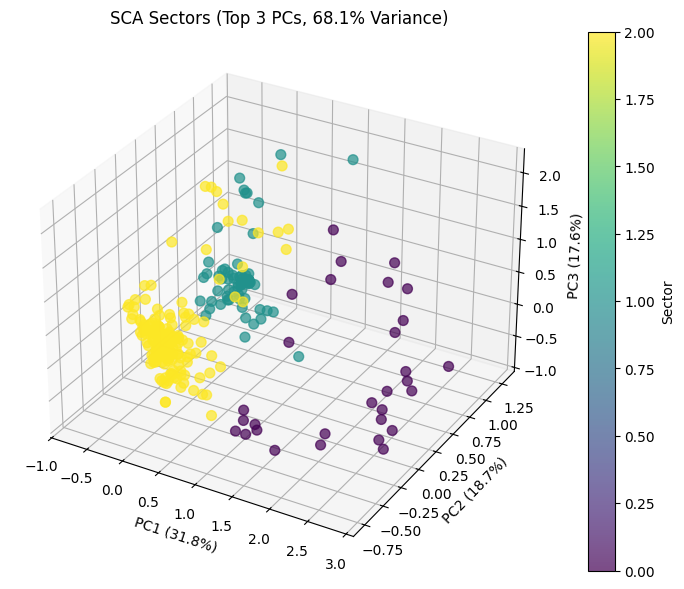

In [150]:
import pandas as pd
df = pd.DataFrame(pcs, columns=['PC1', 'PC2', 'PC3'])
df['Sector'] = clusters

explained_variance = pca.explained_variance_ratio_

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot (color by sector)
scatter = ax.scatter(
    df['PC1'], df['PC2'], df['PC3'],
    c=df['Sector'], cmap='viridis', s=50, alpha=0.7
)

# Label axes with variance explained
ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({explained_variance[2]*100:.1f}%)')
plt.title(f"SCA Sectors (Top 3 PCs, {sum(explained_variance)*100:.1f}% Variance)")
plt.colorbar(scatter, label='Sector')
plt.show()

problem: I don't want to assign a cluster to poins when i'm not confident where they should fall. I'm going to try a ''gaussian mixture.''

[ 0  0  0  0  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1  0 -1
  0  0  0  0  0 -1  0  0  0  0  0  0  0 -1  0  0 -1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0
 -1  0  0  0  0  0  0  0 -1  0 -1  0  0  0  0  1  0  0  0  0 -1  0  2  1
  0 -1  0  0  0  0  1  0  0 -1  0  0 -1  0  0  0  0  0  0 -1 -1  0  0  0
  0 -1  0  0  0 -1  0  0  1 -1  0 -1 -1  0  0  0  0  0  0 -1  1  0  0 -1
 -1  0  0  0  0  0  0  0  0 -1 -1  0  1 -1  1  0  0  0 -1  0 -1  0  0  0
  0 -1  0 -1 -1  1  0  0  0  0 -1  0  0  0  0  0 -1  1  0  0  0  0  0 -1
  0 -1  0  0  1  0  2  0 -1  0  1  0  0 -1  1  0  0  1  1  0 -1  1  1 -1
 -1  0  1  2  0  0  0 -1  0  0  0  0 -1 -1 -1  1  0 -1  0  0  0  1  2  0
  0  0  0  0  0  0  1  0  1  0  0  1 -1  0  0 -1  0  0 -1 -1  1  0 -1  0
 -1 -1  0  0  0  0  0  0  0 -1  0 -1  0  0  0  1  0 -1 -1  0 -1  0 -1  0
  0  0  0  0 -1  0 -1 -1 -1  1  0  0  0  0  0  1  0

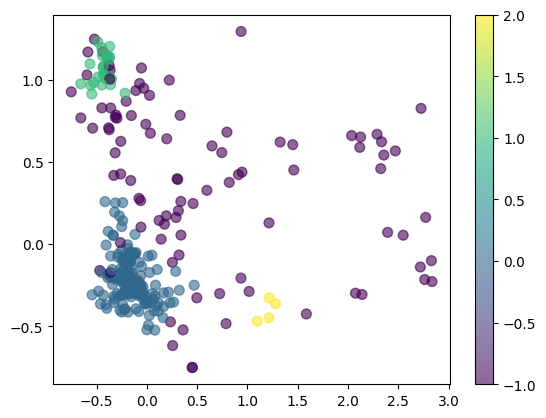

In [214]:
from sklearn.cluster import DBSCAN

# DBSCAN automatically leaves outliers as "-1"
dbscan = DBSCAN(eps=0.16, min_samples=4)  # Tune these!
clusters = dbscan.fit_predict(pcs[:, :3])

# Plot
plt.scatter(pcs[:, 0], pcs[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.6)
plt.colorbar()
print(clusters)

Now compute entropies, joint entropies

Entropy shape: (1229,) (one value per position)


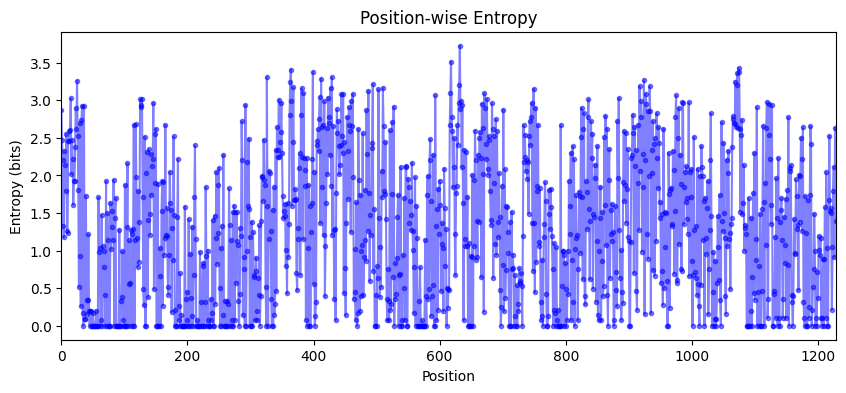

In [110]:
def calculate_entropy(msa_matrix, num_aas=20):  
    n_positions = msa_matrix.shape[1]
    entropy = np.zeros(n_positions)
    
    for pos in range(n_positions):
        column = msa_matrix[:, pos]
        mask = (column != 20)  # Ignore gaps (assuming 20 = gap)
        counts = np.bincount(column[mask], minlength=num_aas)  # Only count AAs 0-19
        frequencies = counts / counts.sum()
        entropy[pos] = -np.sum(frequencies * np.log2(frequencies, where=(frequencies > 0)))
    
    return entropy


num_seqs, num_positions = msa_matrix.shape

entropy = calculate_entropy(msa_matrix)
print(f"Entropy shape: {entropy.shape} (one value per position)")

# Plot
plt.figure(figsize=(10, 4))
plt.plot(entropy, '-o', markersize=3, color = 'Blue', alpha = 0.5)
plt.xlabel("Position")
plt.ylabel("Entropy (bits)")
plt.title("Position-wise Entropy")
plt.xlim(0, num_positions)
plt.show()

corrected covariance calculation

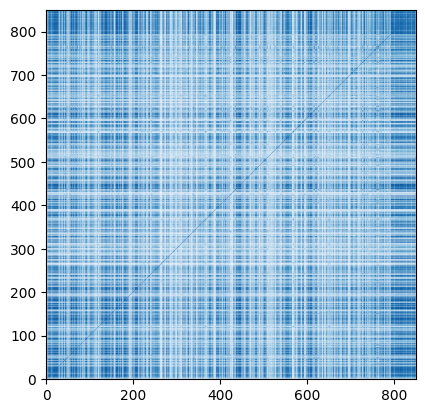

In [111]:
plt.imshow(cov_filt, cmap = 'Blues', origin = 'lower')

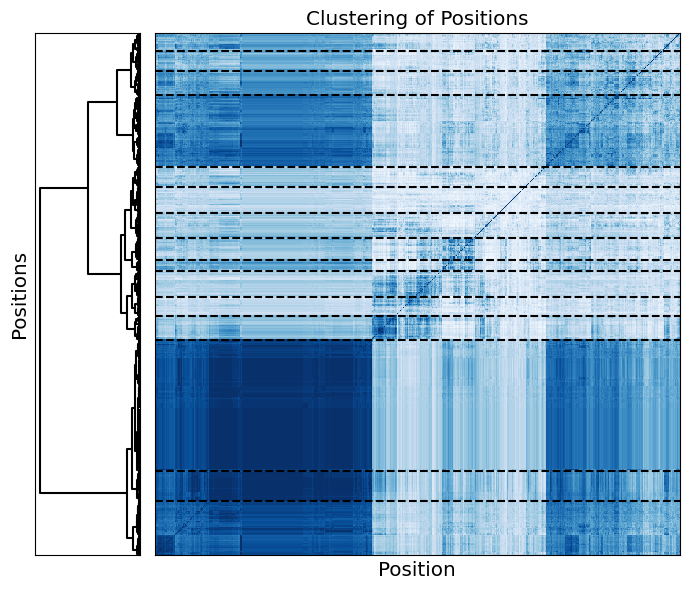

In [112]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from matplotlib.colors import to_hex
import numpy as np
import matplotlib.pyplot as plt


Z = linkage(pdist(cov_filt, metric='euclidean'), method='ward')


n_clusters = 15
clusters = fcluster(Z, t=n_clusters, criterion='maxclust')


dendro = dendrogram(Z, no_plot=True)
leaf_indices = dendro['leaves']


cmap = plt.cm.turbo
cluster_colors = [to_hex(cmap(i)) for i in np.linspace(0, 1, n_clusters)]

def color_func(link_idx):
    if link_idx < len(clusters):  # Only color leaf nodes
        return cluster_colors[clusters[link_idx] - 1]
    return "#000000"


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 6), gridspec_kw={'width_ratios': [0.2, 1]})


dendrogram(Z,
           orientation='left',
           ax=ax1,
           color_threshold=max(Z[-n_clusters+1, 2], 0.1),
           link_color_func=color_func,
           above_threshold_color='k')

ax1.set_ylabel('Positions', fontsize='x-large')
ax1.set_xticks([])
ax1.set_yticks([])


rearranged_data = cov_filt[leaf_indices][:, leaf_indices]
im = ax2.imshow(rearranged_data, aspect='auto', cmap='Blues',
                interpolation='nearest', origin='lower', vmin=0, vmax=1)


boundaries = np.where(np.diff(clusters[leaf_indices]))[0]
for b in boundaries:
    ax2.axhline(b + 0.5, color='black', linestyle='--')

ax2.set_title('Clustering of Positions', fontsize='x-large')
ax2.set_xlabel('Position', fontsize='x-large')
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()

In [113]:
print(cov.shape)

(1229, 1229)


pymol stuff. first collect a reference

In [114]:
from mgsa.structures import struct2seq
from mgsa.io import load_pdb_structure

fpath = '../out/structure/K00370/1Q16.pdb'

ref_str = load_pdb_structure(fpath, '1Q16')
seq = struct2seq(ref_str)

print(seq)
#print(len(seq))

aln_seq = '--------------------------------------------------------SKFLDRFRYFKQKGETFADGHGQLLNTNRDWEDGYRQRWQHDKIVRSTHGVNCTGSCSWKIYVKNGLVTWETQQTDYPRTRPDLPNHEPRGCPRGASYSWYLYSANRLKYPMMRKRLMKMWREAKAL-HSDPVEAWASIIEDADKAKSFKQARGRGGFVRSSWQEVNELIAASNVYTIKNYGPDRVAGFSPIPAMSMVSYASGARYLSLIGGTCLSFYDWYCDLPPASPQTWGEQTDVPESADWYNSSYIIAWGSNVPQTRTPDAHFFTEVRYKGTKTVAVTPDYAEIAKLCDLWLAPKQGTDAMALAMGHVMLREFHLDN---PSQYFTDYVRRYTDMPMLVMLEER------------DGYYAAGRMLRAADLVDAL----------------------GQENNPEWKTVAFNT-NGEMVAPNGSIGFRWGE--------KGKWNLEQRDGKTG-EETELQLSLLGS----QDEIAEVGFPYFGGDGTE--HFNKVEL-ENVLLHKLPVKRLQLADG---STALVTTVYDLTLANYGLER-GLNDVNCATSYDD-VKAYTPAWAEQITGVSRSQIIRIAREFADNADKTHGRSMIIVGAGLNHWYHLDMNYRGLINMLIFCGCVGQSGGGWAHYVGQEKLRPQTGWQPLAFALDWQRPARHMNSTSYFYNHSSQWRYETVTAEELLSPMAD----KSRYTGHLIDFNVRAERMGWLPSAPQLGTNPLTIAGEAEKAGMN----PVDYTVKSLKEGSIRFAAEQPENGKNHPRNLFIWRSNLLGSSGKGHEFMLKYLLGTEHGIQGKDLGQQGGVKPEEVDWQDNGLEGKLDLVVTLDFRLSSTCLYSDIILPTATWYEKDDMNTSDMHPFIHPLSAAVDPAWEAKSDWEIYKAIAKKFSEVCVGHLGK-ETDIVTLPI--QHDSAAELAQ--PLD-VKDW-KKGECDLIPGKTAPHIMVVERDYPATYERFTSIGPLMEKIGNGGKGIAWNTQSEMDLLRKLNYTKA-EGPAKGQPMLNTAIDAAEMILTLAPETNGQVAVKAWAALSEFTGR-DHTHLALNKEDEKIRFRDIQAQPRKIISSPTWSGLEDEHVSYNAGYTNVHELIPWRTLSGRQQLYQDHQWMRDFGESLLVYRPPIDTRSVKEVIGQK-SNGNQEKALNFLTPHQKWGIHSTYSDNLLMLTLGRGGPV-VWLSEADADLGIADNDWIEVFNSNGALTARAVVSQRVPAGMTMMYHAQERIVNLPGSEITQ-QRGGIHNSVTRITPKPTHMIGGYAHLAYGFNYYGTVGSNRDEFVVVRKMK--NIDWLDGEGNDQVQES-----------------------------------'

#print(len(aln_seq))
print(aln_seq)

SKFLDRFRYFKQKGETFADGHGQLLNTNRDWEDGYRQRWQHDKIVRSTHGVNCTGSCSWKIYVKNGLVTWETQQTDYPRTRPDLPNHEPRGCPRGASYSWYLYSANRLKYPMMRKRLMKMWREAKALHSDPVEAWASIIEDADKAKSFKQARGRGGFVRSSWQEVNELIAASNVYTIKNYGPDRVAGFSPIPAMSMVSYASGARYLSLIGGTCLSFYDWYCDLPPASPQTWGEQTDVPESADWYNSSYIIAWGSNVPQTRTPDAHFFTEVRYKGTKTVAVTPDYAEIAKLCDLWLAPKQGTDAAMALAMGHVMLREFHLDNPSQYFTDYVRRYTDMPMLVMLEERDGYYAAGRMLRAADLVDALGQENNPEWKTVAFNTNGEMVAPNGSIGFRWGEKGKWNLEQRDGKTGEETELQLSLLGSQDEIAEVGFPYFGGDGTEHFNKVELENVLLHKLPVKRLQLADGSTALVTTVYDLTLANYGLERGLNDVNCATSYDDVKAYTPAWAEQITGVSRSQIIRIAREFADNADKTHGRSMIIVGAGLNHWYHLDMNYRGLINMLIFCGCVGQSGGGWAHYVGQEKLRPQTGWQPLAFALDWQRPARHMNSTSYFYNHSSQWRYETVTAEELLSPMADKSRYTGHLIDFNVRAERMGWLPSAPQLGTNPLTIAGEAEKAGMNPVDYTVKSLKEGSIRFAAEQPENGKNHPRNLFIWRSNLLGSSGKGHEFMLKYLLGTEHGIQGKDLGQQGGVKPEEVDWQDNGLEGKLDLVVTLDFRLSSTCLYSDIILPTATWYEKDDMNTSDMHPFIHPLSAAVDPAWEAKSDWEIYKAIAKKFSEVCVGHLGKETDIVTLPIQHDSAAELAQPLDVKDWKKGECDLIPGKTAPHIMVVERDYPATYERFTSIGPLMEKIGNGGKGIAWNTQSEMDLLRKLNYTKAEGPAKGQPMLNTAIDAAEMILTLAPETNGQVAVKAWAALSEFTGRDHTHLALNKEDEKIRFRDIQ

In [115]:
print(clean_columns)
print(remove)

x = df['Sector']
x = [int(val) for val in df['Sector']]
print(len(x))
print(x)

[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265

In [193]:
import numpy as np
from Bio import AlignIO, pairwise2
from Bio.Seq import Seq

def create_position_mappings(original_seq, full_msa_seq, clean_columns, removed):
    """
    Creates proper position mappings through all filtering steps
    
    Args:
        original_seq: The reference sequence without gaps
        full_msa_seq: The reference sequence from MSA (with gaps)
        clean_columns: Columns retained after first gap filtering
        removed: Columns removed from clean_columns in second filtering
        
    Returns:
        Tuple of (final_to_msa, msa_to_original)
    """
    # 1. First create mapping from original sequence to full MSA positions
    align = pairwise2.align.globalxx(Seq(original_seq), 
                                   Seq(full_msa_seq.replace('-', '')))[0]
    
    # Create original_seq to full MSA mapping
    orig_to_full_msa = {}
    orig_pos = 0
    msa_pos = 0
    
    for orig_char, msa_char in zip(align[0], align[1]):
        if orig_char != '-' and msa_char != '-':
            orig_to_full_msa[orig_pos] = msa_pos
            orig_pos += 1
        elif orig_char != '-' and msa_char == '-':
            orig_pos += 1
            
        if msa_char != '-':
            msa_pos += 1
    
    # 2. Create mapping through filtering steps
    # full MSA positions → first filtered positions
    full_to_filtered = {full_pos: i for i, full_pos in enumerate(clean_columns)}
    
    # first filtered positions → final positions
    final_positions = np.setdiff1d(np.arange(len(clean_columns)), removed, assume_unique=True)
    filtered_to_final = {filt_pos: i for i, filt_pos in enumerate(final_positions)}
    
    # 3. Combine mappings: original position → final position
    final_to_original = {}
    for orig_pos, full_msa_pos in orig_to_full_msa.items():
        if full_msa_pos in full_to_filtered:
            filtered_pos = full_to_filtered[full_msa_pos]
            if filtered_pos in filtered_to_final:
                final_pos = filtered_to_final[filtered_pos]
                final_to_original[final_pos] = orig_pos
    
    return final_to_original

def get_final_mapping(original_seq, msa_records, clean_columns, removed):
    """
    Gets the complete mapping from final MSA positions to original sequence
    
    Args:
        original_seq: Reference sequence without gaps
        msa_records: List of MSA records from AlignIO
        clean_columns: Columns kept after first filtering
        removed: Columns removed from clean_columns
        
    Returns:
        List where index = final position, value = original position (or None)
    """
    # Find the reference sequence in the MSA
    ref_seq_in_msa = None
    for record in msa_records:
        if record.id == "reference":  # Adjust this to match your reference ID
            ref_seq_in_msa = str(record.seq)
            break
    
    if ref_seq_in_msa is None:
        raise ValueError("Reference sequence not found in MSA")
    
    # Create the complete mapping
    mapping = create_position_mappings(original_seq, ref_seq_in_msa, clean_columns, removed)
    
    # Determine number of final positions
    num_final_pos = len(np.setdiff1d(np.arange(len(clean_columns)), removed))
    
    # Create list mapping (final position → original position)
    final_mapping = [None] * num_final_pos
    for final_pos, orig_pos in mapping.items():
        final_mapping[final_pos] = orig_pos
    
    return final_mapping

In [209]:
index_map = get_final_mapping(seq, msa, np.array(clean_columns), np.array(remove))
sector_indices = index_map
sector_assignment = [int(element) for element in clusters]

for i, item in enumerate(sector_assignment):
    if item == -1:
        sector_assignment[i]= 3
        
print(sector_assignment)



[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 2, 1, 0, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 1, 3, 0, 3, 1, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 1, 3, 1, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 3, 0, 1, 3, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 1, 0, 2, 0, 1, 0, 1, 0, 0, 3, 1, 0, 0, 1, 1, 0, 3, 1, 1, 3, 3, 0, 1, 2, 0, 0, 0, 3, 0, 0, 0, 0, 3, 3, 1, 1, 0, 3, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 3, 3, 1, 0, 1, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 3, 3, 0, 3, 0, 3, 0, 0, 0, 0, 0, 3, 0, 3, 1, 3, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 